In [1]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    import numpy as np
    import random
    import tensorflow as tf

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()


set_seeds()

2025-01-23 12:06:34.405841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 12:06:35.054675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pathlib import Path

import tensorflow as tf

print(tf.config.list_physical_devices("GPU"))

import numpy as np
import matplotlib.pyplot as plt

from csbdeep.utils import axes_dict
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
from csbdeep.utils import axes_dict, plot_some
from csbdeep.data import RawData, create_patches

2025-01-23 12:06:35.692894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 12:06:35.707266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 12:06:35.707432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create data crops 

In [ ]:
parent_folder = Path('"/group/jug/Vera/data/dexm/')
source_dirs_train = ["train/synth_crop"]
source_dirs_val = ["val/synth_crop"]
target_dirs_train = "train/original_crop"
target_dirs_val = "val/original_crop"

raw_data_train = RawData.from_folder(
    basepath=parent_folder,
    source_dirs=source_dirs_train,
    target_dir=target_dirs_train,
    axes="ZYX",
)

raw_data_val = RawData.from_folder(
    basepath=parent_folder,
    source_dirs=source_dirs_val,
    target_dir=target_dirs_val,
    axes="ZYX",
)

X, Y, axes = create_patches(
    raw_data=raw_data_train,
    patch_size=(8, 32, 32),
    n_patches_per_image=10,
    save_file="/group/jug/Vera/data/dexm/train/train_data_dexm.npz",
)

X_val, Y_val, XY_axes_val = create_patches(
    raw_data=raw_data_val,
    patch_size=(8, 32, 32),
    n_patches_per_image=10,
    save_file="/group/jug/Vera/data/dexm/val/val_data_dexm.npz",
)

number of training images:	 2080
number of validation images:	 0
image size (3D):		 (8, 32, 32)
axes:				 SZYXC
channels in / out:		 1 / 1
number of training images:	 240
number of validation images:	 0
image size (3D):		 (8, 32, 32)
axes:				 SZYXC
channels in / out:		 1 / 1
shape of X,Y = (2080, 8, 32, 32, 1)
axes  of X,Y = SZYXC


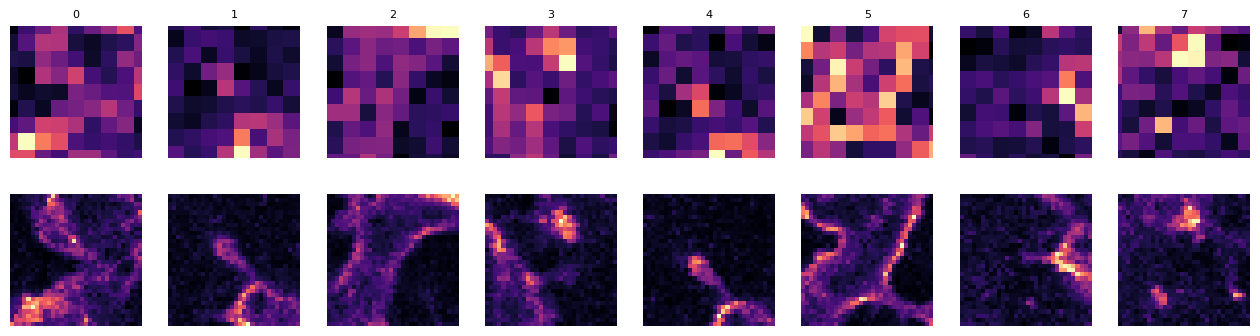

In [3]:
(X, Y), _, axes = load_training_data(
    "/group/jug/Vera/data/dexm/train/train_data_dexm.npz",
    validation_split=0,
    verbose=True,
)
(X_val, Y_val), _, axes = load_training_data(
    "/group/jug/Vera/data/dexm/val/val_data_dexm.npz", validation_split=0, verbose=True
)

assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", axes)


for i in range(1):
    plt.figure(figsize=(16, 4))
    sl = slice(8 * i, 8 * (i + 1)), 0
    plot_some(X_val[sl], Y_val[sl], title_list=[np.arange(sl[0].start, sl[0].stop)])
    plt.show()

In [4]:
c = axes_dict(axes)["C"]
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

config = Config(
    axes, n_channel_in, n_channel_out, train_steps_per_epoch=len(X) // 16
)  # 16 is the default batch size
print(config)
vars(config)

model = CARE(config, "csbdeep", basedir="./experiments/")
print(model.keras_model.summary())
history = model.train(X, Y, validation_data=(X_val, Y_val))

Config(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=1, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=True, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='linear', unet_input_shape=(None, None, None, 1), train_loss='mae', train_epochs=100, train_steps_per_epoch=130, train_learning_rate=0.0004, train_batch_size=16, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0})


/localscratch/micromamba/envs/tf-n2v/lib/python3.10/site-packages/csbdeep/models/base_model.py:203: UserWarning: output path for model already exists, files may be overwritten: /localscratch/dev/pipeline repository/exploratory_notebooks/experiments/csbdeep
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2025-01-23 12:06:36.754095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 12:06:36.754273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, None, None,    0         []                            
                             1)]                                                                  
                                                                                                  
 down_level_0_no_0 (Conv3D)  (None, None, None, None, 3   896       ['input[0][0]']               
                             2)                                                                   
                                                                                                  
 down_level_0_no_1 (Conv3D)  (None, None, None, None, 3   27680     ['down_level_0_no_0[0][0]']   
                             2)                                                               

s-bus-pci#L344-L355
2025-01-23 12:06:37.218427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 12:06:37.218541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-23 12:06:37.218634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11480 MB memory:  -> device: 0, name: NVIDIA A40-16Q, pci bus id: 0000:02:00.0, compute capability: 8.6


None
Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7fad2094cb80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7fad2094cb80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<l

2025-01-23 12:06:39.690903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-01-23 12:06:40.553832: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab6e027c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-23 12:06:40.553879: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40-16Q, Compute Capability 8.6
2025-01-23 12:06:40.557554: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 12:06:40.665204: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/130 [============================>.] - ETA: 0s - loss: 0.0866 - mse: 0.0221 - mae: 0.0866

2025-01-23 12:06:44.514026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


130/130 [==============================] - 7s 19ms/step - loss: 0.0866 - mse: 0.0221 - mae: 0.0866 - val_loss: 0.0700 - val_mse: 0.0155 - val_mae: 0.0700 - lr: 4.0000e-04
Epoch 2/100
130/130 [==============================] - 2s 16ms/step - loss: 0.0696 - mse: 0.0165 - mae: 0.0696 - val_loss: 0.0661 - val_mse: 0.0145 - val_mae: 0.0661 - lr: 4.0000e-04
Epoch 3/100
130/130 [==============================] - 2s 15ms/step - loss: 0.0659 - mse: 0.0148 - mae: 0.0659 - val_loss: 0.0661 - val_mse: 0.0129 - val_mae: 0.0661 - lr: 4.0000e-04
Epoch 4/100
130/130 [==============================] - 2s 16ms/step - loss: 0.0638 - mse: 0.0140 - mae: 0.0638 - val_loss: 0.0639 - val_mse: 0.0139 - val_mae: 0.0639 - lr: 4.0000e-04
Epoch 5/100
130/130 [==============================] - 2s 15ms/step - loss: 0.0630 - mse: 0.0136 - mae: 0.0630 - val_loss: 0.0624 - val_mse: 0.0123 - val_mae: 0.0624 - lr: 4.0000e-04
Epoch 6/100
130/130 [==============================] - 2s 15ms/step - loss: 0.0618 - mse: 0.0131 

In [5]:
axes

'SZYXC'

In [6]:
# load best model and predict
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

model = CARE(config=None, name="csbdeep", basedir="./experiments/")

ssim = []
psnr = []
for input, target in zip(X_val, Y_val):
    prediction = model.predict(input, "ZYXC")[:, :, :, 0]
    target = target[:, :, :, 0]
    ssim.append(
        structural_similarity(
            target, prediction, data_range=target.max() - target.min()
        )
    )
    psnr.append(
        peak_signal_noise_ratio(
            target, prediction, data_range=target.max() - target.min()
        )
    )

print(np.mean(ssim), np.mean(psnr))

Loading network weights from 'weights_best.h5'.
0.5787931736905882 23.41033762989434
